# Census income classification with XGBoost

**Note: the example in this notebook is modified based on the tutorial example from SHAP package. The main modification is Part 2 to undestand the shap loss values.**

This notebook demonstrates how to use XGBoost to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit [github](https://github.com/slundberg/shap/tree/master/notebooks).

Gradient boosting machine methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP ([arXiv paper](https://arxiv.org/abs/1802.03888)) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ XGBoost code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand XGBoost model predictions (Part 1); use SHAP loss values to demonstrate model debugging, monitoring (Part 2).

## Table of Contents
[Part 1: SHAP values](#part-1)<br>

    
[Part 2: SHAP loss values](#part-2)<br>
1. [Entire dataset](#entire-dataset)<br>
2. [Training dataset](#training-dataset)<br>
3. [Test dataset](#test-dataset)<br>
4. [Comparison of training dataset and test dataset](#monitoring-plot)<br>

In [20]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scipy

# print the JS visualization code to the notebook
shap.initjs()

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
# add the helper functions for this example
import sys
sys.path.insert(0, "./helper_functions/")

In [53]:
from shap_help import subsample_data, plot_shap_loss, plot_shap_loss_compare

<a id='part-1'></a>
# Part 1

## Regular SHAP values: feature contribution to prediction

## 1. Load dataset

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [64]:
print(X.columns.tolist())

['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']


In [65]:
X.shape

(32561, 12)

**check some basic information**

In [3]:
print(X.shape)

print("imbalance ratio: entire dataset")
print(y.sum()/len(y))

print("imbalance ratio: training dataset")
print(y_train.sum()/len(y_train))

print("imbalance ratio: test dataset")
print(y_test.sum()/len(y_test))

(32561, 12)
imbalance ratio: entire dataset
0.2408095574460244
imbalance ratio: training dataset
0.24105497542997542
imbalance ratio: test dataset
0.23982803623522186


In [4]:
X.describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,3.868892,10.080679,2.611836,6.572740,2.494518,3.665858,0.669205,1077.648804,87.303833,40.437454,36.718866
std,13.640432,1.455960,2.572720,1.506222,4.228857,1.758232,0.848806,0.470506,7385.291992,402.960205,12.347429,7.823782
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,4.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000
50%,37.000000,4.000000,10.000000,2.000000,7.000000,3.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000
75%,48.000000,4.000000,12.000000,4.000000,10.000000,4.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000


**Note: there may be some potential issue here since we treat all the categotical variables as numberical variables, but let us ingore this in this example**

## 2. Train the model

In [5]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54663
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.36373
[200]	test-logloss:0.31793
[300]	test-logloss:0.30061
[400]	test-logloss:0.29207
[500]	test-logloss:0.28678
[600]	test-logloss:0.28381
[700]	test-logloss:0.28181
[800]	test-logloss:0.28064
[900]	test-logloss:0.27992
[1000]	test-logloss:0.27928
Stopping. Best iteration:
[999]	test-logloss:0.27927



## 3. Classic feature attributions

Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

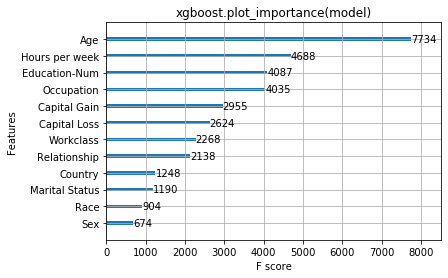

In [6]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

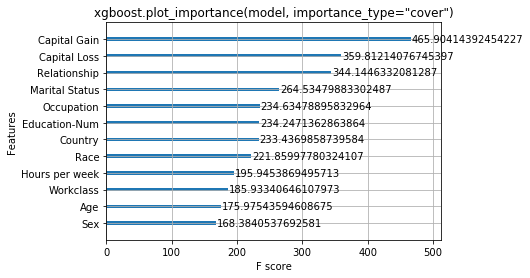

In [7]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

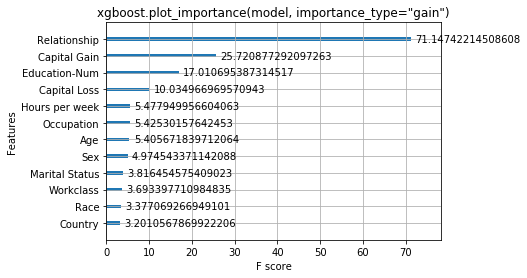

In [8]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## 4. Explain predictions

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples).

In [9]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [10]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

### Visualize many predictions

To keep the browser happy we only visualize 1,000 individuals.

In [11]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

## 5. Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

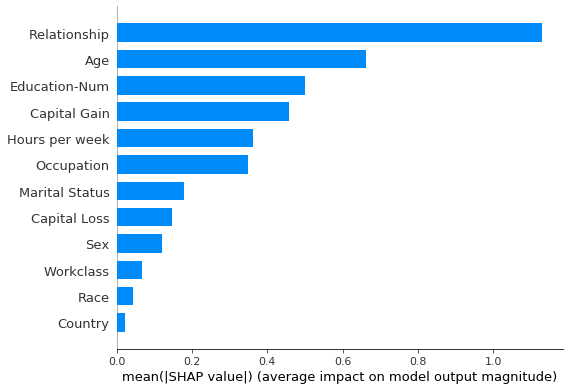

In [12]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

## 6. SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

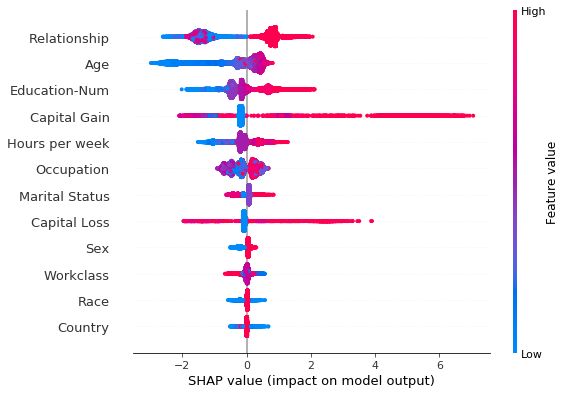

In [13]:
shap.summary_plot(shap_values, X)

<a id='part-2'></a>
# Part 2

## Explain the Log-Loss of the Model with TreeExplainer

note that the `expected_value` of the model's loss dependes on the label so it is now a function instead of a single number. More details later.

<a id='entire-dataset'></a>
### 1. Calculate the shap loss values on the entire dataset

In [17]:
# subsample to provide the background data (stratified by the target variable)

X_subsample = subsample_data(X, y, n_sample=100, seed_temp=1234)

In [19]:
explainer_bg_100 = shap.TreeExplainer(model, X_subsample, 
                                      feature_perturbation="interventional", 
                                      model_output="log_loss")

shap_values_logloss_all = explainer_bg_100.shap_values(X, y)

100%|===================| 32557/32561 [32:17<00:00]        

In [21]:
pd.DataFrame(shap_values_logloss_all, columns=X.columns).to_pickle("./shap_values/shap_logloss_total_bg_100.pkl")

**Verify the additivity of construction to the model outcome (here the logloss)**

In [30]:
model_loss = -np.log(model.predict(xgboost.DMatrix(X)))*y \
                + -np.log(1-model.predict(xgboost.DMatrix(X)))*(1-y)

**check the consistency of the first 10 instances**

In [31]:
model_loss[:10]

array([0.02519595, 0.33307654, 0.01530153, 0.07925388, 0.41296351,
       1.58259666, 0.00634701, 0.95363694, 0.00700874, 0.03172347])

In [33]:
explainer_bg_100.shap_values(X.iloc[:10,:], y[:10]).sum(1) + \
    np.array([explainer_bg_100.expected_value(v) for v in y[:10]])

array([0.02519602, 0.3355711 , 0.01530154, 0.07925381, 0.41296293,
       1.5825986 , 0.00634703, 0.95363641, 0.00700876, 0.03172338])

**check the calculation of expected values**

In [71]:
print(explainer_bg_100.expected_value(True))

print(explainer_bg_100.expected_value(False))

2.999368503203383
0.4383577679593923


In [72]:
# the calculation of expected values is based on the background data

X_subsample_index = X_subsample.index
y_subsample = y[X_subsample_index]

In [73]:
### conditional on label

# for instance with True label
y_temp = np.array([True]*len(y_subsample)) # switch all the label to True

model_loss_condition_true = -np.log(model.predict(xgboost.DMatrix(X_subsample)))*y_temp \
                                + -np.log(1-model.predict(xgboost.DMatrix(X_subsample)))*(1-y_temp)

# for instance with False label
y_temp = np.array([False]*len(y_subsample)) # switch all the label to False

model_loss_condition_false = -np.log(model.predict(xgboost.DMatrix(X_subsample)))*y_temp \
                                + -np.log(1-model.predict(xgboost.DMatrix(X_subsample)))*(1-y_temp)

                                          
print(len(model_loss_condition_true))
print(len(model_loss_condition_false))

print("Expected model logloss (based on 100 samples), condition on True: ", model_loss_condition_true.mean())
print("Expected model logloss (based on 100 samples), condition on False: ", model_loss_condition_false.mean())

100
100
Expected model logloss (based on 100 samples), condition on True:  2.9992899041157215
Expected model logloss (based on 100 samples), condition on False:  0.43840519708755893


### 1.1. Examples: force plot to understand the contribution to loss

In [34]:
# model prediction: probability/score of being True
y_predict = model.predict(xgboost.DMatrix(X))

**case 1: ground truth 0 and predict 0**

In [66]:
i = 0
print("data label:", y[i])
print("model prediction:", y_predict[i])
print("log loss: ", model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X.iloc[i,:])

data label: False
model prediction: 0.024881208
log loss:  0.025195952504873276


**case 2: ground truth 1 and predict 1**

In [68]:
i = 8
print("data label:", y[i])
print("model prediction:", y_predict[i])
print("log loss: ", model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X_display.iloc[i,:])

data label: True
model prediction: 0.99301577
log loss:  0.00700873788446188


**case 3: ground truth 0 and predict 1**

In [38]:
i = 5
print(y[i])
print(y_predict[i])
print(model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X.iloc[i,:])

False
0.79455906
1.5825966596603394


**case 4: ground truth 1 and predict 0**

In [70]:
i = 7
print("data label:", y[i])
print("model prediction:", y_predict[i])
print("log loss: ", model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X_display.iloc[i,:])

data label: True
model prediction: 0.38533702
log loss:  0.9536369442939758


### 1.2 SHAP loss value plot

In [40]:
top_features = ["Relationship", "Age", "Education-Num", "Capital Gain"]

SHAP loss value plot



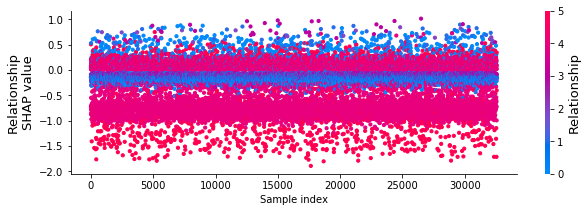

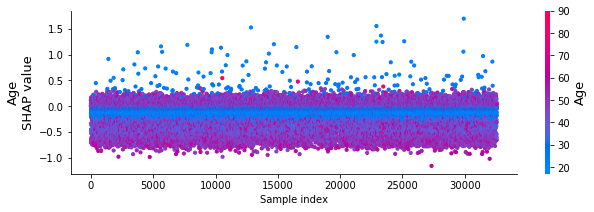

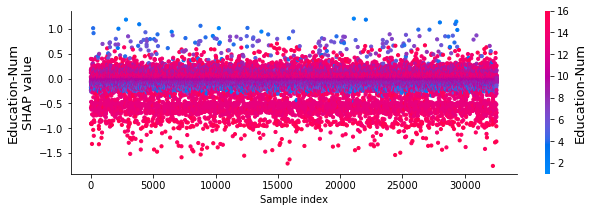

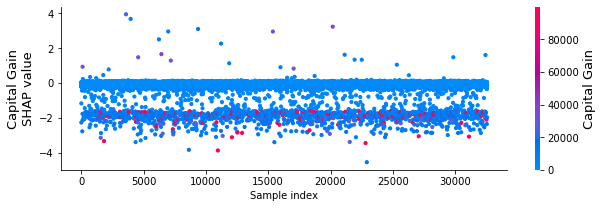

In [41]:
print("SHAP loss value plot\n")

for feat in top_features:
    plot_shap_loss(feat_name=feat, shap_values_logloss=shap_values_logloss_all, data_X=X)


**summary plot 1**

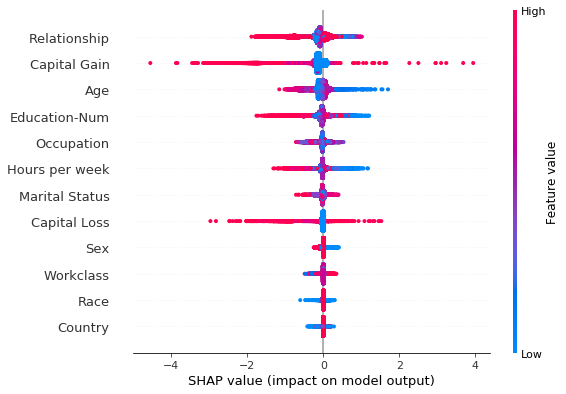

In [42]:
shap.summary_plot(shap_values_logloss_all, X)

**summary plot 2**

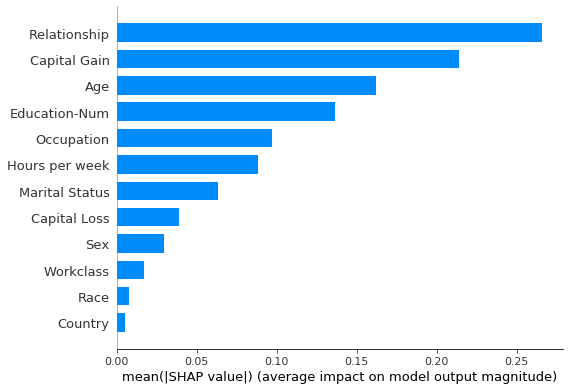

In [43]:
shap.summary_plot(shap_values_logloss_all, X, plot_type="bar")

**summary plot (decompose to negative and positive)**

In [44]:
shap_values_logloss_all_pd = pd.DataFrame(shap_values_logloss_all, columns=X.columns)

# positive
shap_values_logloss_all_sum_pos_pd = shap_values_logloss_all_pd.apply(lambda x: x[x>=0.0].sum(), axis=0)

# negative
shap_values_logloss_all_sum_neg_pd = shap_values_logloss_all_pd.apply(lambda x: x[x<0.0].sum(), axis=0)

Shap loss values sum (negative)


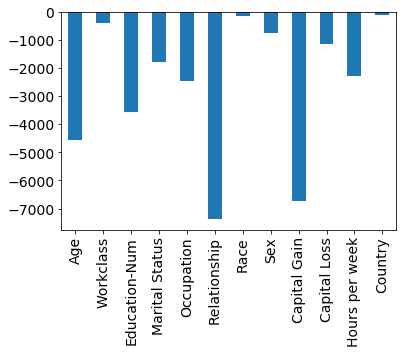

In [45]:
print("Shap loss values sum (negative)")
shap_values_logloss_all_sum_neg_pd.plot.bar(fontsize=14)

Shap loss values sum (positive)


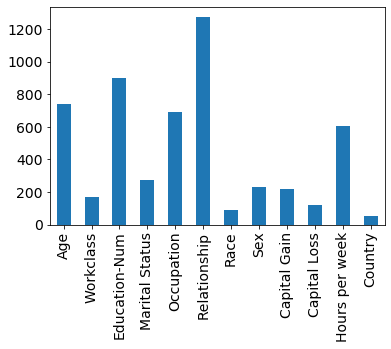

In [46]:
print("Shap loss values sum (positive)")
shap_values_logloss_all_sum_pos_pd.plot.bar(fontsize=14)

<a id='training-dataset'></a>
### 2. SHAP loss value for training data

In [22]:
X_train_subsample = subsample_data(X=X_train, y=y_train)

In [25]:
explainer_train_bg_100 = shap.TreeExplainer(model, X_train_subsample, 
                                            feature_perturbation="interventional", model_output="log_loss")

shap_values_logloss_train = explainer_train_bg_100.shap_values(X_train, y_train)

100%|===================| 26045/26048 [31:24<00:00]        

In [26]:
pd.DataFrame(shap_values_logloss_train, columns=X.columns).to_pickle("./shap_values/shap_logloss_train_bg_100.pkl")

<a id='test-dataset'></a>
### 3. SHAP loss value for test data

In [27]:
X_test_subsample = subsample_data(X=X_test, y=y_test)

In [28]:
explainer_test_bg_100 = shap.TreeExplainer(model, X_test_subsample, 
                                           feature_perturbation="interventional", model_output="log_loss")

shap_values_logloss_test = explainer_test_bg_100.shap_values(X_test, y_test)

100%|===================| 6511/6513 [08:52<00:00]        

In [29]:
pd.DataFrame(shap_values_logloss_test, columns=X.columns).to_pickle("./shap_values/shap_logloss_test_bg_100.pkl")

<a id='monitoring-plot'></a>
### 4. Compare training shap loss value to test shap loss values

In [47]:
shap_values_logloss_train_pd = pd.read_pickle("./shap_values/shap_logloss_train_bg_100.pkl")

shap_values_logloss_test_pd = pd.read_pickle("./shap_values/shap_logloss_test_bg_100.pkl")

In [48]:
# combine the shap loss values from training dataset and test dataset into a list
list_ShapValue_Features = [[shap_values_logloss_train_pd, X_train], 
                           [shap_values_logloss_test_pd, X_test]]

### 4.1. use the original monitoring function from shap package, with a fixed increment of data points 50

**Note: the dash vertical line indicates where the t-test fails**

SHAP loss value plot, training v.s. test



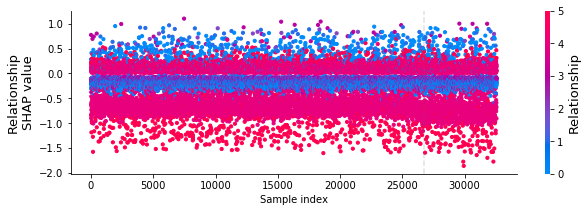

snapshot boundary (index):  [26047]


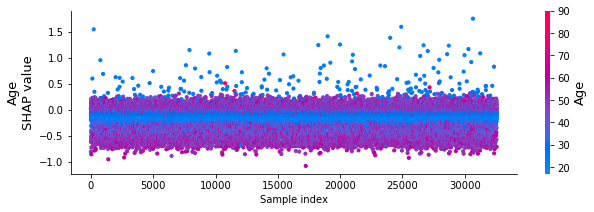

snapshot boundary (index):  [26047]


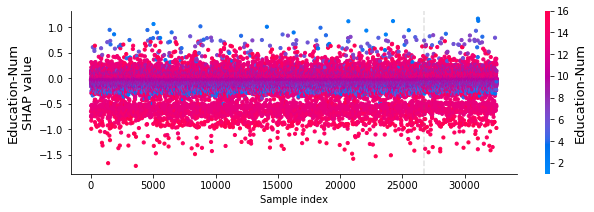

snapshot boundary (index):  [26047]


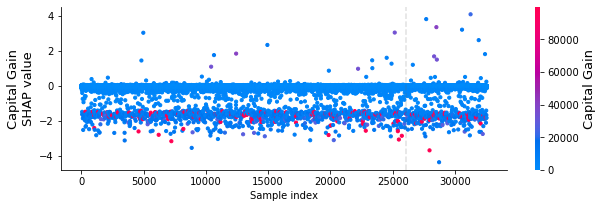

snapshot boundary (index):  [26047]


In [50]:
print("SHAP loss value plot, training v.s. test\n")

top_features = ["Relationship", "Age", "Education-Num", "Capital Gain"]

for feat in top_features:
    plot_shap_loss_compare(feat_name=feat, list_ShapValue_Features=list_ShapValue_Features)

### 4.2 use my customized monitoring function to check the min_pval and min_pval_ind

**Note: here we use the same increment of data points, which is 50**

SHAP loss value plot, training v.s. test

now change the increment of data points for the t- test as:  50 default by shap package is 50
t-test fail:
min_pval:  7.090212865751213e-07 ; min_pval_ind:  26750


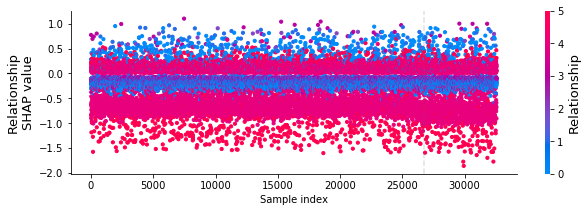

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  50 default by shap package is 50


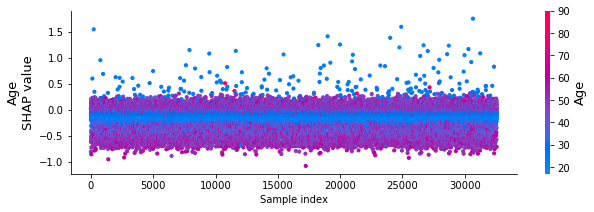

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  50 default by shap package is 50
t-test fail:
min_pval:  9.280217657057468e-07 ; min_pval_ind:  26700


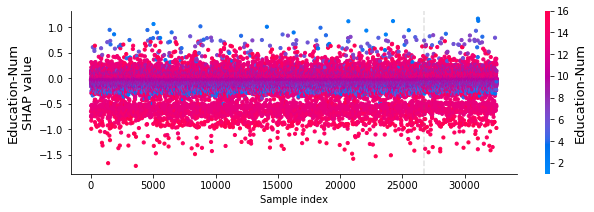

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  50 default by shap package is 50
t-test fail:
min_pval:  1.1549156812983268e-27 ; min_pval_ind:  26050


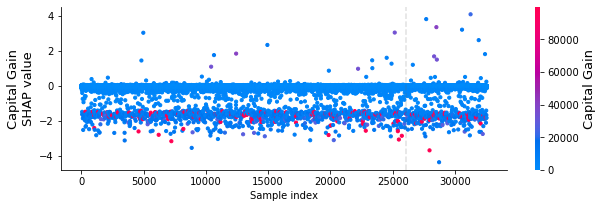

snapshot boundary (index):  [26047]


In [56]:
print("SHAP loss value plot, training v.s. test\n")

top_features = ["Relationship", "Age", "Education-Num", "Capital Gain"]

for feat in top_features:
    plot_shap_loss_compare(feat_name=feat, list_ShapValue_Features=list_ShapValue_Features, 
                           use_fine_tune=True, inc_input=50)

### 4.3. Now change the increment of data points to 6500
**Note: change the increment of data points to 6500 enables us to do the t-test for training data v.s. test data**

In [57]:
print(len(y_train))
print(len(y_test))

26048
6513


SHAP loss value plot, training v.s. test

now change the increment of data points for the t- test as:  6500 default by shap package is 50
t-test fail:
min_pval:  2.5983900962178417e-06 ; min_pval_ind:  26000


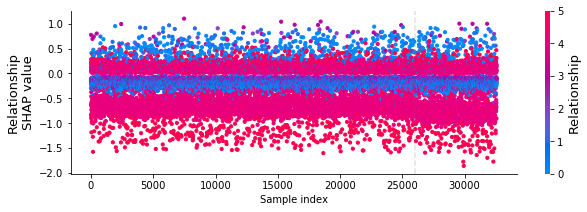

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  6500 default by shap package is 50


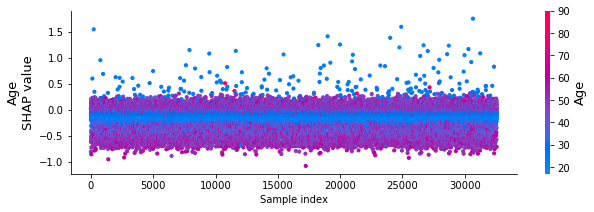

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  6500 default by shap package is 50
t-test fail:
min_pval:  3.2740349128415534e-06 ; min_pval_ind:  26000


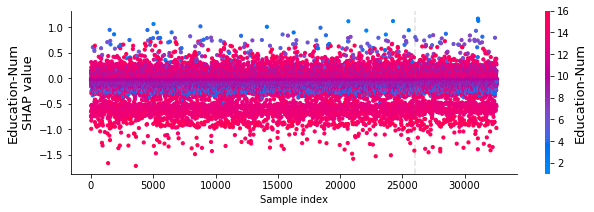

snapshot boundary (index):  [26047]
now change the increment of data points for the t- test as:  6500 default by shap package is 50
t-test fail:
min_pval:  1.1637150903542836e-27 ; min_pval_ind:  26000


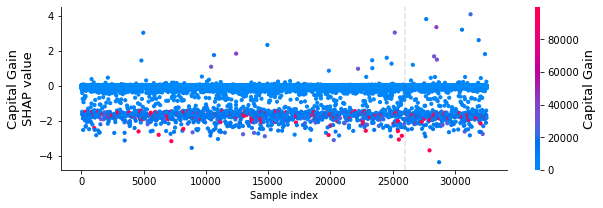

snapshot boundary (index):  [26047]


In [58]:
print("SHAP loss value plot, training v.s. test\n")

top_features = ["Relationship", "Age", "Education-Num", "Capital Gain"]

for feat in top_features:
    plot_shap_loss_compare(feat_name=feat, list_ShapValue_Features=list_ShapValue_Features, 
                           use_fine_tune=True, inc_input=6500)

**t-test for shap loss values on training dataset and test dataset**

In [60]:
for feat in top_features:
    stat, p_val = scipy.stats.ttest_ind(shap_values_logloss_train_pd[feat], 
                                        shap_values_logloss_test_pd[feat])
    
    print("t-test for feature: ", feat, ", p value: ", p_val)

t-test for feature:  Relationship , p value:  2.9102249320497517e-06
t-test for feature:  Age , p value:  0.22246187841821208
t-test for feature:  Education-Num , p value:  4.169244713493427e-06
t-test for feature:  Capital Gain , p value:  1.0471308847541212e-27


In [61]:
for feat in top_features:
    stat, p_val = scipy.stats.ttest_ind(shap_values_logloss_train_pd[feat], 
                                        shap_values_logloss_test_pd[feat], 
                                        equal_var=False)
    print("t-test for feature: ", feat, ", p value: ", p_val)

t-test for feature:  Relationship , p value:  1.427849321056383e-05
t-test for feature:  Age , p value:  0.2367209506867293
t-test for feature:  Education-Num , p value:  3.3161498092593535e-06
t-test for feature:  Capital Gain , p value:  1.697971581168647e-24
